In [1]:
import os
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

# Define folder path
base_folder = "./IDP Group A"

# Define wavelength list (450 nm to 950 nm in 20 nm steps)
wavelengths = list(range(450, 951, 20))

# Define subfolders
sample_folders = [f"d{i}" for i in range(1, 15)]  # d1 to d14
dark_folder = "dark"
white_folder = "white"
reference_folder = "reference image"


# Load white and dark images
def load_cube(folder_path):
    tif_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".tif")]
    tif_files.sort()

    cube = []
    for tif_file in tif_files:
        tif_path = os.path.join(folder_path, tif_file)
        tif = tiff.imread(tif_path)
        cube.append(tif)

    cube = np.array(cube)

    return cube


# Load dark and white reference cubes
dark_cube = load_cube(os.path.join(base_folder, dark_folder))
white_cube = load_cube(os.path.join(base_folder, white_folder))
reference_cube = load_cube(os.path.join(base_folder, reference_folder))


# Avoid division by zero
denominator = white_cube - dark_cube
denominator[denominator == 0] = 1e-6

# Load and compute reflectance for each sample
reflectance_cubes = {}

for folder in sample_folders:
    sample_cube = load_cube(os.path.join(base_folder, folder))
    R = (sample_cube - dark_cube) / denominator
    reflectance_cubes[folder] = R  # Shape: (bands, height, width)

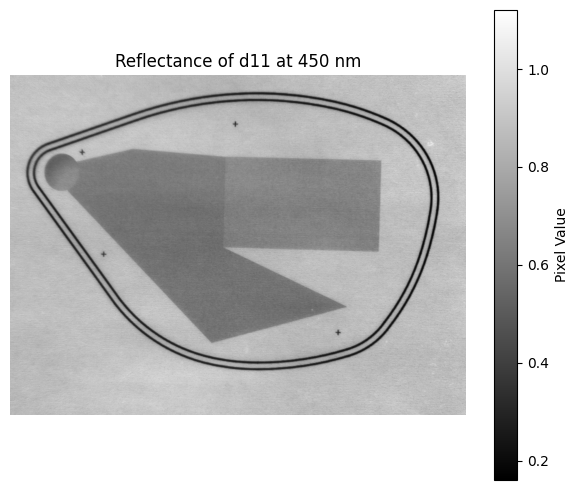

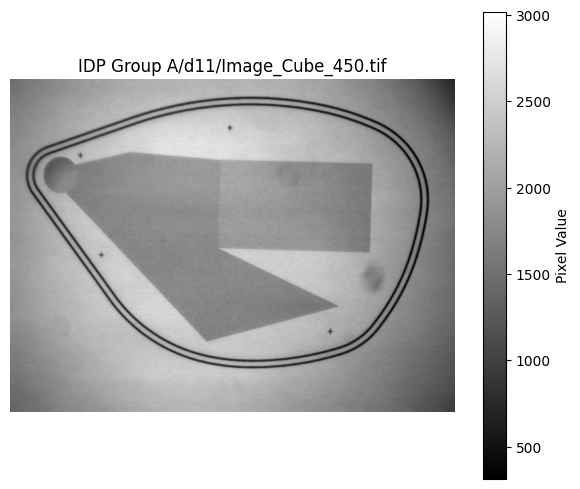

In [2]:
# R_d1 = reflectance_cubes["d1"] # Example: Access reflectance cube for d1


def plot_image(image, title=""):
    # Plot the image
    plt.figure(figsize=(6, 5))
    plt.imshow(image, cmap="gray")
    plt.colorbar(label="Pixel Value")
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def plot_example_reflectance(reflectance_cubes, sample_name, wavelength):
    # Get reflectance cube
    R = reflectance_cubes[sample_name]

    # Extract 2D image at selected wavelength
    reflectance_image = R[wavelengths.index(wavelength), :, :]
    title = f"Reflectance of {sample_name} at {wavelength} nm"

    plot_image(reflectance_image, title)


def plot_original_tif(tif_path):
    image = tiff.imread(tif_path)

    plot_image(image, tif_path)


plot_example_reflectance(reflectance_cubes, "d11", 450)
plot_original_tif("IDP Group A/d11/Image_Cube_450.tif")

In [3]:
from sklearn.cluster import KMeans


def segment_image(reflectance_cubes, sample_name, wavelength, n_clusters=6):
    R = reflectance_cubes[sample_name]

    # Extract image at selected wavelength
    reflectance_image = R[wavelengths.index(wavelength), :, :]

    # Flatten image for k means
    pixels = reflectance_image.reshape(-1, 1)

    # Apply k means clustering
    k_means = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    labels = k_means.fit_predict(pixels)

    # Reshape labels to image shape
    segmented_image = labels.reshape(reflectance_image.shape)

    return segmented_image


segmented_image = segment_image(reflectance_cubes, "d11", 450)

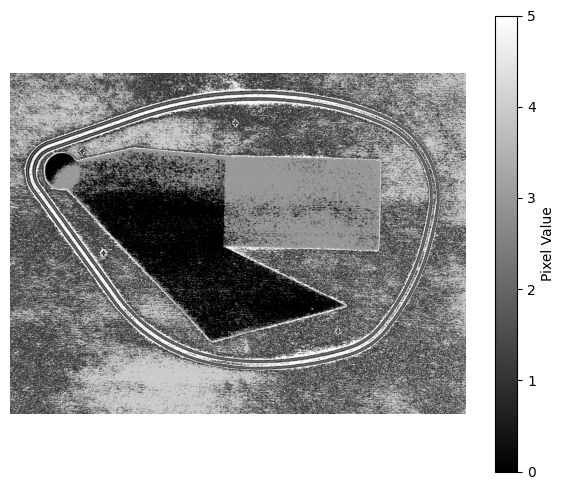

In [4]:
plot_image(segmented_image)